<a href="https://colab.research.google.com/github/Alenushka2013/ML_for_people_tasks/blob/main/HW_2_4_Boosting_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/Alenushka2013/Coursera/refs/heads/master/Datasets/bank-customer-churn-prediction.csv', index_col=0)
X_test = pd.read_csv('/content/test.csv', index_col=0).iloc[:, 2:]
train_df, val_df = split_train_val(raw_df.iloc[:, 2:], 'Exited')
X_train, train_targets = separate_inputs_targets(train_df, train_df.columns[:-1], train_df.columns[-1])
X_val, val_targets = separate_inputs_targets(val_df, val_df.columns[:-1], val_df.columns[-1])

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [3]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,  roc_auc_score

xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    device='cuda'
)

xgb_clf.fit(X_train, train_targets)

train_proba = xgb_clf.predict_proba(X_train)[:, 1]
val_proba = xgb_clf.predict_proba(X_val)[:, 1]

print('Train AUROC', round(roc_auc_score(train_targets, train_proba), 5))
print('Validation AUROC', round(roc_auc_score(val_targets, val_proba), 5))


Train AUROC 0.93296
Validation AUROC 0.93262


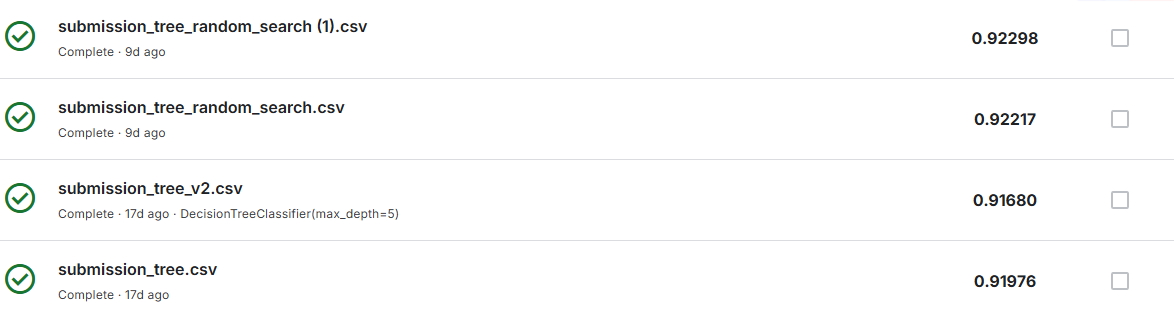

**Висновки:**

Близькі та досить високі значення метрики на тренувальних та валідаційних даних свідчать про те, що модель добре генералізує на нових даних. Модель має кращі результати в порівнянні з моєю найкращою моделлю DecisionTrees.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [5]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, accuracy_score

In [6]:
! pip freeze | grep xgboost

xgboost==3.0.2


In [45]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        #use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        train_targets,
        eval_set=[(X_val, val_targets)],
        verbose=False)
    pred = clf.predict_proba(X_val)[:, 1]
    AUROC = roc_auc_score(val_targets, pred)


    return {'loss': -AUROC, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)  # max_evals=20 кількість ітерацій


# Перетворення значень гіперпараметрів у кінцеві типи даних
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    #use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, train_targets)

final_pred_train = final_clf.predict_proba(X_train)[:, 1]
final_AUROC_train = roc_auc_score(train_targets, final_pred_train)
print("Точність на тренувальній вибірці: {:.5f}".format(final_AUROC_train))

final_pred_val = final_clf.predict_proba(X_val)[:, 1]
final_AUROC_val = roc_auc_score(val_targets, final_pred_val)
print("Точність на валідаційній вибірці: {:.5f}".format(final_AUROC))

100%|██████████| 50/50 [00:12<00:00,  4.06trial/s, best loss: -0.9376596474380959]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.6742271739507513), 'gamma': np.float64(0.41742628252413955), 'learning_rate': np.float64(0.1124385659092804), 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 225, 'reg_alpha': np.float64(0.5446488705861751), 'reg_lambda': np.float64(0.6338060644422736), 'subsample': np.float64(0.725284085187097)}
Точність на тренувальній вибірці: 0.95633
Точність на валідаційній вибірці: 0.93624


**Висновки:**

Результат ще трохи покращився, і модель гарно працює.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [21]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [22]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

In [33]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    # missing=np.nan,  # явне вказування пропущених значень
    # # device='cuda'  # використовувати GPU для прискорення обчислень
    verbose = -1
)

lgb_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

train_pred = lgb_clf.predict(X_train)
val_pred = lgb_clf.predict(X_val)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

train_proba = lgb_clf.predict_proba(X_train)[:, 1]
val_proba = lgb_clf.predict_proba(X_val)[:, 1]

print('Train AUROC', round(roc_auc_score(train_targets, train_proba), 5))
print('Validation AUROC', round(roc_auc_score(val_targets, val_proba), 5))

              precision    recall  f1-score   support

         0.0     0.9184    0.9632    0.9403      9558
         1.0     0.8219    0.6650    0.7352      2442

    accuracy                         0.9025     12000
   macro avg     0.8701    0.8141    0.8377     12000
weighted avg     0.8988    0.9025    0.8985     12000

              precision    recall  f1-score   support

         0.0     0.9175    0.9590    0.9378      2390
         1.0     0.8048    0.6623    0.7266       610

    accuracy                         0.8987      3000
   macro avg     0.8612    0.8106    0.8322      3000
weighted avg     0.8946    0.8987    0.8949      3000

Train AUROC 0.93881
Validation AUROC 0.93622


**Висновки:**

Близькі та досить високі значення метрики на тренувальних та валідаційних даних свідчать про те, що модель добре генералізує на нових даних. Модель має кращі результати в порівнянні зі звичайною XGBoostClassifier, без підбору гіперпараметрів.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [42]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
    pred_proba = clf.predict_proba(X_val)[:, 1]
    AUROC = roc_auc_score(val_targets, pred_proba)

    return {'loss': -AUROC, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
final_pred = final_clf.predict(X_val)
final_pred_proba = final_clf.predict_proba(X_val)[:, 1]
final_AUROC = roc_auc_score(val_targets, final_pred_proba)

# print("Точність на валідаційній вибірці: {:.5f}".format(final_AUROC), end = '\n')

print(classification_report(val_targets, final_pred, digits=5),  end = '\n')

print("Точність на валідаційній вибірці: {:.5f}".format(final_AUROC), end = '\n')

100%|██████████| 10/10 [00:05<00:00,  1.73trial/s, best loss: -0.9362418547225462]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.7737048841534889), 'learning_rate': np.float64(0.08420440911431885), 'max_depth': 3, 'min_child_weight': 10, 'min_split_gain': np.float64(0.07508505597049454), 'n_estimators': 350, 'num_leaves': 130, 'reg_alpha': np.float64(0.02405216299320223), 'reg_lambda': np.float64(0.7247471927450458), 'subsample': np.float64(0.9996442225434016)}
              precision    recall  f1-score   support

         0.0    0.92336   0.95774   0.94023      2390
         1.0    0.80614   0.68852   0.74271       610

    accuracy                        0.90300      3000
   macro avg    0.86475   0.82313   0.84147      3000
weighted avg    0.89952   0.90300   0.90007      3000

Точність на валідаційній вибірці: 0.93624


6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [43]:
X_test_predict = final_clf.predict_proba(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Exited'] = X_test_predict[:, 1]
df_sample.to_csv('/content/submission_LightGBM.csv', index=False)

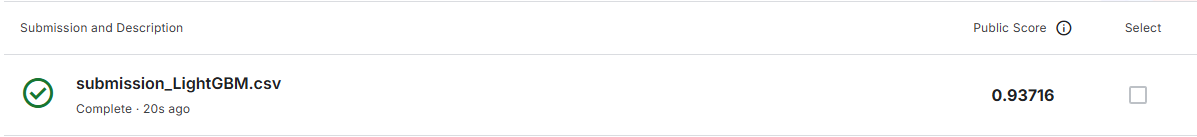

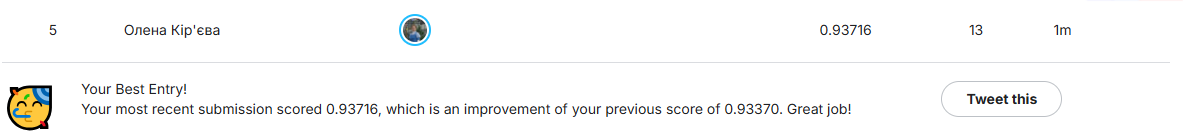